# Multi-Class Deep Learning Model for Fashion-MNIST Using Keras Take 3
### David Lowe
### December 23, 2019

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The purpose of this project is to construct a predictive model using various machine learning algorithms and to document the end-to-end steps using a template. The Fashion MNIST dataset is a multi-class classification situation where we are trying to predict one of several (more than two) possible outcomes.

INTRODUCTION: Fashion-MNIST is a MNIST-like fashion product dataset from Zalando Research. It consists of a training set of 60,000 clothing article examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Zalando intends Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.

For the Take1 iteration, we constructed a simple dense-layer model to classify the images. This model serves as the baseline for future iterations.

For the Take2 iteration, we tuned the simple dense-layer model further to examine whether we can improve its prediction performance.

For this iteration, we will convert the dense-layer model into a convolutional model to examine whether we can improve its performance.

ANALYSIS: For the Take1 iteration, the baseline performance of the model achieved an accuracy score of 88.58% after training for three epochs. The same baseline model processed the test dataset with an accuracy of 87.72%. If we were to train the model much further than three epochs, we could run into the over-fitting issue.

For the Take2 iteration, the performance of the Take2 model with the default parameters achieved an accuracy score of 91.68% after training for ten epochs. After tuning the hyperparameters, the Take2 model with the best hyperparameters processed the training dataset with an accuracy of 91.82%. The same Take2 model processed the test dataset with an accuracy of 89.20%.

For the Take2 iteration, tuning the hyperparameters does not appear to have a noticeable effect on the model accuracy. The reason could be that, for image recognition, a simple dense-layer model can only do so much.

For this iteration, the performance of the Take3 model with the default parameters achieved an accuracy score of 95.67% after training for ten epochs. After tuning the hyperparameters, the Take3 model with the best hyperparameters processed the training dataset with an accuracy of 94.51%. The same Take2 model processed the test dataset with an accuracy of 91.68%.

For the Take3 iteration, adding the convolutional layers improved the model's prediction performance. The increasing difference between training and validation accuracy after each epoch indicated that we potentially have a high variance problem. We will need more data to train the model before we can bring up the prediction accuracy of the validation dataset.

CONCLUSION: For this dataset, the model built using Keras and TensorFlow achieved a satisfactory result and should be considered for future modeling activities.

Dataset Used: Fashion-MNIST Dataset

Dataset ML Model: Multi-class classification with numerical attributes

Dataset Reference: https://github.com/zalandoresearch/fashion-mnist

One potential source of performance benchmarks: https://www.kaggle.com/zalando-research/fashionmnist

Any deep-learning modeling project genrally can be broken down into about six major tasks:

0. Prepare Environment
1. Load Data
2. Define Model
3. Fit and Evaluate Model
4. Optimize Model
5. Finalize Model

# Section 0. Prepare Environment

In [1]:
# Set the warning message filter
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
# Set the random seed number for reproducible results
seedNum = 888

In [3]:
# Load libraries and packages
import random
random.seed(seedNum)
import numpy as np
np.random.seed(seedNum)
import tensorflow as tf
tf.random.set_seed(seedNum)
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
# import keras as K
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.wrappers.scikit_learn import KerasClassifier
import pandas as pd
import math
import os
import sys
import shutil
import urllib.request
import zipfile
import smtplib
import matplotlib.pyplot as plt
from datetime import datetime
from email.message import EmailMessage
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import preprocessing

In [4]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the verbose flag to print detailed messages for debugging (setting to True will activate)
# verbose = True
# tf.debugging.set_log_device_placement(verbose)

# Set up the number of CPU cores available for multi-thread processing
n_jobs = -1
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

# Set the number of folds for cross validation
n_folds = 5

# Set the flag for splitting the dataset
splitDataset = True
splitPercentage = 0.25

# Set various default Keras modeling parameters
default_loss = 'categorical_crossentropy'
default_metrics = ['accuracy']
default_kernel_init = tf.initializers.RandomNormal(seed=seedNum)
default_optimizer = tf.optimizers.Adam(learning_rate=0.001)
default_epoch = 10
default_batch = 32

Num GPUs Available:  0


In [5]:
# Reset the random number generators
def reset_random(seedNum):
    random.seed(seedNum)
    np.random.seed(seedNum)
    tf.random.set_seed(seedNum)

In [6]:
# Set up the email notification function
def email_notify(msg_text):
    sender = os.environ.get('MAIL_SENDER')
    receiver = os.environ.get('MAIL_RECEIVER')
    gateway = os.environ.get('SMTP_GATEWAY')
    smtpuser = os.environ.get('SMTP_USERNAME')
    password = os.environ.get('SMTP_PASSWORD')
    if sender==None or receiver==None or gateway==None or smtpuser==None or password==None:
        sys.exit("Incomplete email setup info. Script Processing Aborted!!!")
    msg = EmailMessage()
    msg.set_content(msg_text)
    msg['Subject'] = 'Notification from Keras Multi-Class Classification Script'
    msg['From'] = sender
    msg['To'] = receiver
    server = smtplib.SMTP(gateway, 587)
    server.starttls()
    server.login(smtpuser, password)
    server.send_message(msg)
    server.quit()

In [7]:
if (notifyStatus): email_notify("Phase 0 Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 1. Load Data

In [8]:
if (notifyStatus): email_notify("Phase 1 Load Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## 1.a) Load Dataset

In [9]:
mnist = tf.keras.datasets.fashion_mnist
(X_train, y_train),(X_test, y_test) = mnist.load_data()

# Summarize loaded datasets
print('Train Shape: X=%s, y=%s' % (X_train.shape, y_train.shape))
print('Test Shape: X=%s, y=%s' % (X_test.shape, y_test.shape))

4423680/4422102 [==============================] - 0s 0us/step
Train Shape: X=(60000, 28, 28), y=(60000,)
Test Shape: X=(10000, 28, 28), y=(10000,)


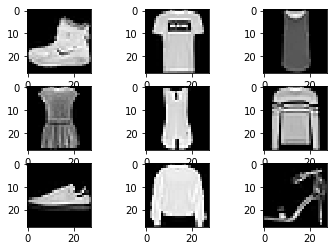

In [10]:
# Plot first few images
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
plt.show()

## 1.b) Data Cleaning

In [11]:
# Not required for this iteration of the project

## 1.c) Feature Scaling and Pre-processing

In [12]:
# Reshape the input data as [samples][width][height][channels]
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')

# Apply feature scaling and transformation
X_train = X_train / 255.0
X_test = X_test / 255.0

## 1.d) Splitting Data into Training and Test Sets

In [13]:
# Encode class values as integers and perform one-hot-encoding
encoder = preprocessing.LabelEncoder()
encoder.fit(y_train)
train_transformed = encoder.transform(y_train)
test_transformed = encoder.transform(y_test)
y_train = tf.keras.utils.to_categorical(train_transformed)
y_test = tf.keras.utils.to_categorical(test_transformed)

print('Train Shape: X=%s, y=%s' % (X_train.shape, y_train.shape))
print('Test Shape: X=%s, y=%s' % (X_test.shape, y_test.shape))

num_pixels = X_train.shape[1] * X_train.shape[2]
num_classes = y_train.shape[1]

Train Shape: X=(60000, 28, 28, 1), y=(60000, 10)
Test Shape: X=(10000, 28, 28, 1), y=(10000, 10)


In [14]:
if (notifyStatus): email_notify("Phase 1 Load Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 2. Define Model

In [15]:
if (notifyStatus): email_notify("Phase 2 Define Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [16]:
# Define the Keras model required for KerasClassifier
def create_default_model():
    default_model = Sequential()
    default_model.add(Conv2D(64, (3,3), activation='relu', input_shape=(28, 28, 1)))
    default_model.add(MaxPooling2D(2, 2))
    default_model.add(Conv2D(64, (3,3), activation='relu'))
    default_model.add(MaxPooling2D(2, 2))
    default_model.add(Flatten())
    default_model.add(Dense(128, activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(num_classes, activation='softmax', kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer, metrics=default_metrics)
    return default_model

In [17]:
# Define the Callback class and early-stopping function
# class myCallback(tf.keras.callbacks.Callback):
#     def on_epoch_end(self, epoch, logs={}):
#         if(logs.get('accuracy') > 0.9):
#             print("\nReached 90% accuracy so cancelling training!")
#             self.model.stop_training = True

# callbacks = myCallback()

In [18]:
if (notifyStatus): email_notify("Phase 2 Define Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 3. Fit and Evaluate Model

In [19]:
if (notifyStatus): email_notify("Phase 3 Fit and Evaluate Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [20]:
# Initialize the baseline model
startTimeModule = datetime.now()
reset_random(seedNum)
baseline_model = create_default_model()
baseline_hist = baseline_model.fit(X_train, y_train, epochs=default_epoch, batch_size=default_batch,
                                   validation_data=(X_test, y_test), verbose=1)
print('Total time for creating the baseline model:', (datetime.now() - startTimeModule))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 71s 1ms/sample - loss: 0.4700 - accuracy: 0.8280 - val_loss: 0.3589 - val_accuracy: 0.8704
Epoch 2/10
60000/60000 [==============================] - 65s 1ms/sample - loss: 0.3106 - accuracy: 0.8857 - val_loss: 0.3082 - val_accuracy: 0.8921
Epoch 3/10
60000/60000 [==============================] - 65s 1ms/sample - loss: 0.2645 - accuracy: 0.9026 - val_loss: 0.2767 - val_accuracy: 0.8991
Epoch 4/10
60000/60000 [==============================] - 65s 1ms/sample - loss: 0.2318 - accuracy: 0.9136 - val_loss: 0.2733 - val_accuracy: 0.9028
Epoch 5/10
60000/60000 [==============================] - 65s 1ms/sample - loss: 0.2039 - accuracy: 0.9235 - val_loss: 0.2509 - val_accuracy: 0.9111
Epoch 6/10
60000/60000 [==============================] - 65s 1ms/sample - loss: 0.1809 - accuracy: 0.9325 - val_loss: 0.2656 - val_accuracy: 0.9101
Epoch 7/10
60000/60000 [==============================] 

In [21]:
# Display a summary of the baseline model
print(baseline_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               204928    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1

In [22]:
# Display the configuration of the baseline model
print(baseline_model.get_config())

{'name': 'sequential', 'layers': [{'class_name': 'Conv2D', 'config': {'name': 'conv2d', 'trainable': True, 'batch_input_shape': (None, 28, 28, 1), 'dtype': 'float32', 'filters': 64, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}}, {'class_name': 'MaxPooling2D', 'config': {'name': 'max_pooling2d', 'trainable': True, 'dtype': 'float32', 'pool_size': (2, 2), 'padding': 'valid', 'strides': (2, 2), 'data_format': 'channels_last'}}, {'class_name': 'Conv2D', 'config': {'name': 'conv2d_1', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'valid', 'data_for

In [23]:
# List all data points in the baseline model training history
print(baseline_hist.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


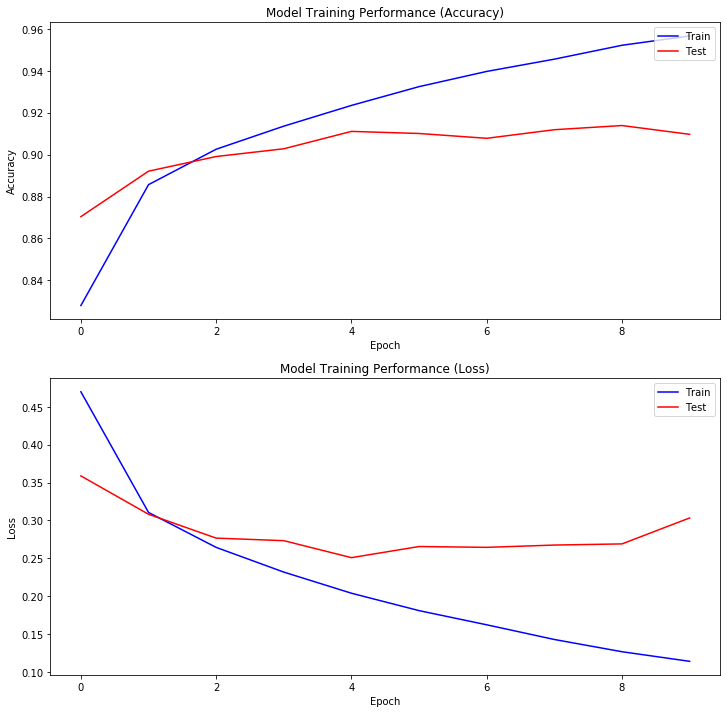

In [24]:
# Summarize model training hisotry for accuracy and loss
fig, axs = plt.subplots(2, 1, figsize=(12,12))
plt.subplot(211)
plt.plot(baseline_hist.history['accuracy'], color='blue', label='train')
plt.plot(baseline_hist.history['val_accuracy'], color='red', label='test')
plt.title('Model Training Performance (Accuracy)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.subplot(212)
plt.plot(baseline_hist.history['loss'], color='blue', label='train')
plt.plot(baseline_hist.history['val_loss'], color='red', label='test')
plt.title('Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [25]:
if (notifyStatus): email_notify("Phase 3 Fit and Evaluate Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 4. Optimize Model

In [26]:
if (notifyStatus): email_notify("Phase 4 Optimize Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [27]:
# Define the Keras model required for KerasClassifier
def create_customized_model(optimizer, kernel_init):
    customized_model = Sequential()
    customized_model.add(Conv2D(64, (3,3), activation='relu', input_shape=(28, 28, 1)))
    customized_model.add(MaxPooling2D(2, 2))
    customized_model.add(Conv2D(64, (3,3), activation='relu'))
    customized_model.add(MaxPooling2D(2, 2))
    customized_model.add(Flatten())
    customized_model.add(Dense(128, activation='relu', kernel_initializer=kernel_init))
    customized_model.add(Dense(num_classes, activation='softmax', kernel_initializer=kernel_init))
    customized_model.compile(loss=default_loss, optimizer=optimizer, metrics=default_metrics)
    return customized_model

In [28]:
startTimeModule = datetime.now()

# Set up grid search using different epochs, batch sizes, and optimizers
optz_1 = tf.optimizers.Adam(learning_rate=0.001)
optz_2 = tf.optimizers.Adam(learning_rate=0.0001)
optz_3 = tf.optimizers.RMSprop(learning_rate=0.001)
optz_4 = tf.optimizers.RMSprop(learning_rate=0.0001)
optimizer_grid = [optz_1, optz_2, optz_3, optz_4]
print('Optimizer candidate #1 has the object ID of', optz_1)
print('Optimizer candidate #2 has the object ID of', optz_2)
print('Optimizer candidate #3 has the object ID of', optz_3)
print('Optimizer candidate #3 has the object ID of', optz_4)

init_1 = tf.initializers.RandomNormal(seed=seedNum)
init_2 = tf.initializers.Orthogonal(seed=seedNum)
init_3 = tf.initializers.GlorotNormal(seed=seedNum)
init_grid = [init_1, init_2, init_3]
print('Initializer candidate #1 has the object ID of', init_1)
print('Initializer candidate #2 has the object ID of', init_2)
print('Initializer candidate #2 has the object ID of', init_3)

epoch_grid = [10]
batch_grid = [32, 64, 128]

best_score = 0
grid_iteration = 0
best_iteration = 0
best_optimizer = default_optimizer
best_kernel_init = default_kernel_init
best_epoch = default_epoch
best_batch = default_batch

for optimizer in optimizer_grid:
    for kernel_init in init_grid:
        for epoch_num in epoch_grid:
            for batch_num in batch_grid:
                print('\nForming the grid-search model #%d using: optimizer=%s, kernel=%s, epochs=%d, batch_size=%d'
                      % (grid_iteration, optimizer, kernel_init, epoch_num, batch_num))
                reset_random(seedNum)
                grid_model = create_customized_model(optimizer, kernel_init)
                grid_hist = grid_model.fit(X_train, y_train, epochs=epoch_num, batch_size=batch_num, 
                                       validation_data=(X_test, y_test), verbose=1)
                if(grid_hist.history['val_accuracy'][-1] > best_score):
                    best_score = grid_hist.history['val_accuracy'][-1]
                    best_iteration = grid_iteration
                    best_optimizer = optimizer
                    best_kernel_init = kernel_init
                    best_epoch = epoch_num
                    best_batch = batch_num
                grid_iteration = grid_iteration + 1

# summarize results
print("\nBest score (highest validation accuracy) found via grid search: accuracy=%f from model iteration #%d"
      % (best_score, best_iteration))
print('The best modeling parameters are: optimizer=%s, kernel=%s, epochs=%d, batch_size=%d'
      % (best_optimizer, best_kernel_init, best_epoch, best_batch))
print('Total time for performing grid-search of the best parameters:', (datetime.now() - startTimeModule))

Optimizer candidate #1 has the object ID of <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fb98c0cc510>
Optimizer candidate #2 has the object ID of <tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fb98c0ccd90>
Optimizer candidate #3 has the object ID of <tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop object at 0x7fb98c0cc610>
Optimizer candidate #3 has the object ID of <tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop object at 0x7fb98c0cc350>
Initializer candidate #1 has the object ID of <tensorflow.python.ops.init_ops_v2.RandomNormal object at 0x7fb98c0cc3d0>
Initializer candidate #2 has the object ID of <tensorflow.python.ops.init_ops_v2.Orthogonal object at 0x7fb98c0ccd50>
Initializer candidate #2 has the object ID of <tensorflow.python.ops.init_ops_v2.GlorotNormal object at 0x7fb98c0cc490>

Forming the grid-search model #0 using: optimizer=<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fb98c0cc510>, kernel=<tensorflow.python.ops.in

In [29]:
if (notifyStatus): email_notify("Phase 4 Optimize Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 5. Finalize Model

In [30]:
if (notifyStatus): email_notify("Phase 5 Finalize Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [31]:
# Create the final model for evaluating the test dataset
startTimeModule = datetime.now()
print('Forming the final model using: optimizer=%s, kernel=%s, epochs=%d, batch_size=%d'
      % (best_optimizer, best_kernel_init, best_epoch, best_batch))
np.random.seed(seedNum)
tf.random.set_seed(seedNum)
final_model = create_customized_model(best_optimizer, best_kernel_init)
final_hist = final_model.fit(X_train, y_train, epochs=best_epoch, batch_size=best_batch, verbose=1)
print('Total time for training the final model:', (datetime.now() - startTimeModule))

Forming the final model using: optimizer=<tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop object at 0x7fb98c0cc610>, kernel=<tensorflow.python.ops.init_ops_v2.Orthogonal object at 0x7fb98c0ccd50>, epochs=10, batch_size=128
Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 41s 678us/sample - loss: 0.5556 - accuracy: 0.7961
Epoch 2/10
60000/60000 [==============================] - 40s 660us/sample - loss: 0.3473 - accuracy: 0.8742
Epoch 3/10
60000/60000 [==============================] - 39s 657us/sample - loss: 0.2907 - accuracy: 0.8935
Epoch 4/10
60000/60000 [==============================] - 39s 658us/sample - loss: 0.2562 - accuracy: 0.9060
Epoch 5/10
60000/60000 [==============================] - 39s 656us/sample - loss: 0.2324 - accuracy: 0.9138
Epoch 6/10
60000/60000 [==============================] - 40s 659us/sample - loss: 0.2115 - accuracy: 0.9216
Epoch 7/10
60000/60000 [==============================] - 40s 659us/sample - loss: 0.1920 - acc

In [32]:
# Display a summary of the final model
print(final_model.summary())

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_74 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_74 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_75 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_37 (Flatten)         (None, 1600)              0         
_________________________________________________________________
dense_74 (Dense)             (None, 128)               204928    
_________________________________________________________________
dense_75 (Dense)             (None, 10)              

In [33]:
# Display the configuration of the final model
print(final_model.get_config())

{'name': 'sequential_37', 'layers': [{'class_name': 'Conv2D', 'config': {'name': 'conv2d_74', 'trainable': True, 'batch_input_shape': (None, 28, 28, 1), 'dtype': 'float32', 'filters': 64, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}}, {'class_name': 'MaxPooling2D', 'config': {'name': 'max_pooling2d_74', 'trainable': True, 'dtype': 'float32', 'pool_size': (2, 2), 'padding': 'valid', 'strides': (2, 2), 'data_format': 'channels_last'}}, {'class_name': 'Conv2D', 'config': {'name': 'conv2d_75', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'valid',

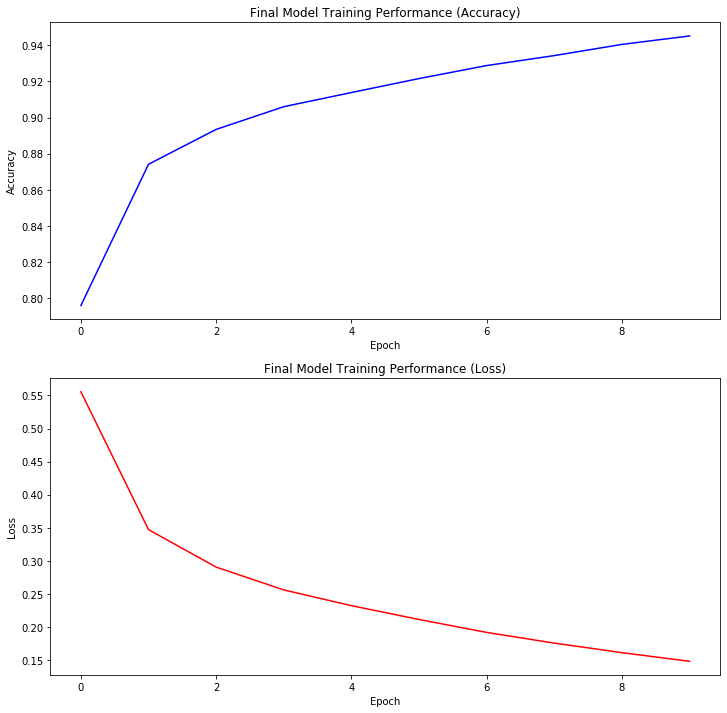

In [34]:
# Summarize model training hisotry for accuracy and loss
fig, axs = plt.subplots(2, 1, figsize=(12,12))
plt.subplot(211)
plt.plot(final_hist.history['accuracy'], color='blue')
plt.title('Final Model Training Performance (Accuracy)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.subplot(212)
plt.plot(final_hist.history['loss'], color='red')
plt.title('Final Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [35]:
# Evaluate the Keras model on previously unseen data
scores = final_model.evaluate(X_test, y_test, verbose=0)
print("The model %s: %f%%" % (final_model.metrics_names[1], scores[1]*100))
print("The model %s: %f" % (final_model.metrics_names[0], scores[0]))

The model accuracy: 91.689998%
The model loss: 0.254754


In [36]:
# Make class predictions with the model
predictions = final_model.predict_classes(X_test)

# Summarize the first 20 cases
for i in range(20):
	print('Data item #%d predicted to be %s (expected %s)' % (i, encoder.inverse_transform([predictions[i]]), encoder.inverse_transform([np.argmax(y_test[i])])))

Data item #0 predicted to be [9] (expected [9])
Data item #1 predicted to be [2] (expected [2])
Data item #2 predicted to be [1] (expected [1])
Data item #3 predicted to be [1] (expected [1])
Data item #4 predicted to be [6] (expected [6])
Data item #5 predicted to be [1] (expected [1])
Data item #6 predicted to be [4] (expected [4])
Data item #7 predicted to be [6] (expected [6])
Data item #8 predicted to be [5] (expected [5])
Data item #9 predicted to be [7] (expected [7])
Data item #10 predicted to be [4] (expected [4])
Data item #11 predicted to be [5] (expected [5])
Data item #12 predicted to be [7] (expected [7])
Data item #13 predicted to be [3] (expected [3])
Data item #14 predicted to be [4] (expected [4])
Data item #15 predicted to be [1] (expected [1])
Data item #16 predicted to be [2] (expected [2])
Data item #17 predicted to be [2] (expected [4])
Data item #18 predicted to be [8] (expected [8])
Data item #19 predicted to be [0] (expected [0])


In [37]:
if (notifyStatus): email_notify("Phase 5 Finalize Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [38]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 5:24:38.815608
